# Machine Learning Project

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

#Unique to this f
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
# Parse data file for model
df = pd.read_csv('variants_with_obj_function.csv')

# Add 16 new columns to the front of the DataFrame
for i in range(16):
    col_name = 'Variant{}'.format(i+1)
    df.insert(i, col_name, df['Variant Combination'])
    df[col_name] = df[col_name].str.slice(i, i+1) # IF need to change A to 1 and B to 0 make it here
#     df[col_name] = df[col_name].replace({'A': -1, 'B': 1})
    
df = df.drop(columns=['Unnamed: 0', 'replicate', 'Variant Combination'])

df = df.loc[df['Objective Function Value'] <= 15]

df_encoded = pd.get_dummies(df, columns=['Variant1', 'Variant2', 'Variant3', 'Variant4', 'Variant5', 'Variant6', 'Variant7', 'Variant8', 'Variant9', 'Variant10', 'Variant11', 'Variant12', 'Variant13', 'Variant14', 'Variant15', 'Variant16'])


print(df_encoded)

       Objective Function Value  Variant1_A  Variant1_B  Variant2_A  \
18                     5.414224           1           0           1   
19                    14.540865           1           0           1   
22                     5.414222           1           0           1   
23                    14.540864           1           0           1   
26                     5.414243           1           0           1   
...                         ...         ...         ...         ...   
65531                  2.970487           0           1           0   
65532                  2.975706           0           1           0   
65533                  2.985979           0           1           0   
65534                  2.919980           0           1           0   
65535                  2.970328           0           1           0   

       Variant2_B  Variant3_A  Variant3_B  Variant4_A  Variant4_B  Variant5_A  \
18              0           1           0           1           0 

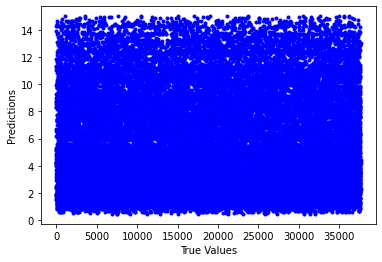

In [3]:
# Split data into training and testing sets
# X = df.iloc[:, :-1] # select all columns except the last one (Objective Function Value)
# y = df.iloc[:, -1] # select only the last column (Objective Function Value)

X = df_encoded.drop(['Objective Function Value'], axis=1)
y = df_encoded['Objective Function Value']
y_sqrt = np.sqrt(y)
y_log = np.log(y + 1)


# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape

# Plot MSE
plt.plot(range(len(y_train)), y_train, '.', color='blue')
# plt.plot(range(20), y_pred[:20], '.', color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()


In [4]:
# Define the MLP model
def create_mlp(input_dim, structure, output_dim):
    model = Sequential()
    
    for i in range(len(structure)):
        if (i == 0):
            model.add(Dense(structure[0], input_dim=input_dim, activation='relu'))
        else:
            model.add(Dense(structure[i], input_dim=structure[i-1], activation='relu'))
    
    
    model.add(Dense(output_dim, activation='linear'))
    return model

In [ ]:
structures = [[10], [10, 10], [10, 10, 10], [10, 10, 10, 10], [10, 10, 10, 10, 10], [10, 10, 10, 10, 10, 10], [10, 10, 10, 10, 10, 10, 10]]

data = []

for structure in structures:
    X_train = X
    y_train = y
    input_dim = X_train.shape[1]
#     structure = [25, 15, 5]
    output_dim = 1

    # Set up the session config to limit GPU memory usage
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(session)

    # Create the model
    with tf.device('/GPU:0'): # specify the GPU to use
        model = create_mlp(input_dim, structure, output_dim)

        # Compile the model with an optimizer and loss function
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

        # Train the model with early stopping
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])

        plt.plot(history.history['mse'])
        plt.plot(history.history['val_mse'])
        plt.title('model accuracy')
        plt.ylabel('MSE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        data.append([structure, min(history.history['val_mse']), len(history.history['val_mse'])])

df = pd.DataFrame(data, columns=('Structure', 'Val MSE', 'Epochs'))
df_sorted = df.sort_values(by='Val MSE')
df_sorted


Epoch 1/100
1176/1176 [==============================] - 1s 779us/step - loss: 19.7305 - mse: 19.7305 - val_loss: 6.7428 - val_mse: 6.7428
Epoch 2/100
1176/1176 [==============================] - 1s 685us/step - loss: 9.8721 - mse: 9.8721 - val_loss: 5.9733 - val_mse: 5.9733
Epoch 3/100
1176/1176 [==============================] - 1s 688us/step - loss: 9.4517 - mse: 9.4517 - val_loss: 6.5342 - val_mse: 6.5342
Epoch 4/100
1176/1176 [==============================] - 1s 697us/step - loss: 8.8418 - mse: 8.8418 - val_loss: 6.2681 - val_mse: 6.2681
Epoch 5/100
1176/1176 [==============================] - 1s 696us/step - loss: 8.4393 - mse: 8.4393 - val_loss: 6.0690 - val_mse: 6.0690
Epoch 6/100
1176/1176 [==============================] - 1s 697us/step - loss: 7.9648 - mse: 7.9648 - val_loss: 6.2583 - val_mse: 6.2583
Epoch 7/100
1176/1176 [==============================] - 1s 699us/step - loss: 7.4258 - mse: 7.4258 - val_loss: 6.4880 - val_mse: 6.4880


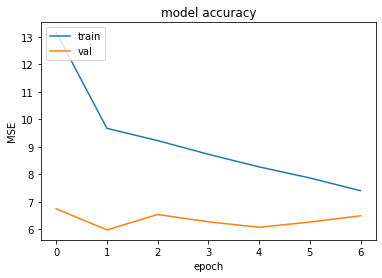

Epoch 1/100
1176/1176 [==============================] - 1s 756us/step - loss: 22.4722 - mse: 22.4722 - val_loss: 6.8173 - val_mse: 6.8173
Epoch 2/100
1176/1176 [==============================] - 1s 784us/step - loss: 9.7772 - mse: 9.7772 - val_loss: 6.7049 - val_mse: 6.7049
Epoch 3/100
1176/1176 [==============================] - 1s 687us/step - loss: 9.6116 - mse: 9.6116 - val_loss: 6.5224 - val_mse: 6.5224
Epoch 4/100
1176/1176 [==============================] - 1s 701us/step - loss: 9.1903 - mse: 9.1903 - val_loss: 7.0664 - val_mse: 7.0664
Epoch 5/100
1176/1176 [==============================] - 1s 702us/step - loss: 8.8039 - mse: 8.8039 - val_loss: 6.9791 - val_mse: 6.9791
Epoch 6/100
1176/1176 [==============================] - 1s 697us/step - loss: 8.5235 - mse: 8.5235 - val_loss: 7.7908 - val_mse: 7.7908
Epoch 7/100
1176/1176 [==============================] - 1s 699us/step - loss: 8.4000 - mse: 8.4000 - val_loss: 7.7472 - val_mse: 7.7472
Epoch 8/100
1176/1176 [================

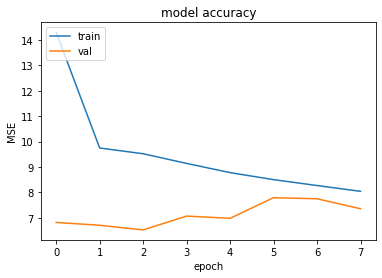

Epoch 1/100
1176/1176 [==============================] - 1s 761us/step - loss: 19.0372 - mse: 19.0372 - val_loss: 6.6784 - val_mse: 6.6784
Epoch 2/100
1176/1176 [==============================] - 1s 692us/step - loss: 9.4099 - mse: 9.4099 - val_loss: 6.6665 - val_mse: 6.6665
Epoch 3/100
1176/1176 [==============================] - 1s 692us/step - loss: 9.1614 - mse: 9.1614 - val_loss: 6.1264 - val_mse: 6.1264
Epoch 4/100
1176/1176 [==============================] - 1s 692us/step - loss: 8.9120 - mse: 8.9120 - val_loss: 6.0293 - val_mse: 6.0293
Epoch 5/100
1176/1176 [==============================] - 1s 690us/step - loss: 8.5785 - mse: 8.5785 - val_loss: 6.1698 - val_mse: 6.1698
Epoch 6/100
1176/1176 [==============================] - 1s 690us/step - loss: 8.0823 - mse: 8.0823 - val_loss: 6.0829 - val_mse: 6.0829
Epoch 7/100
1176/1176 [==============================] - 1s 691us/step - loss: 7.6037 - mse: 7.6037 - val_loss: 6.6383 - val_mse: 6.6383
Epoch 8/100
1176/1176 [================

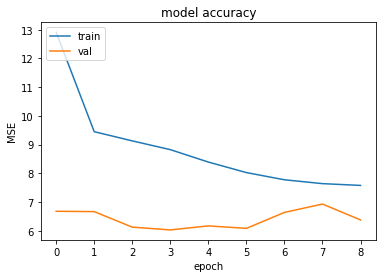

Epoch 1/100
1176/1176 [==============================] - 1s 777us/step - loss: 15.9356 - mse: 15.9356 - val_loss: 6.7453 - val_mse: 6.7453
Epoch 2/100
1176/1176 [==============================] - 1s 701us/step - loss: 9.6862 - mse: 9.6862 - val_loss: 6.0546 - val_mse: 6.0546
Epoch 3/100
1176/1176 [==============================] - 1s 703us/step - loss: 9.2684 - mse: 9.2684 - val_loss: 5.7117 - val_mse: 5.7117
Epoch 4/100
1176/1176 [==============================] - 1s 695us/step - loss: 8.7244 - mse: 8.7244 - val_loss: 5.9234 - val_mse: 5.9234
Epoch 5/100
1176/1176 [==============================] - 1s 700us/step - loss: 8.4378 - mse: 8.4378 - val_loss: 5.5799 - val_mse: 5.5799
Epoch 6/100
1176/1176 [==============================] - 1s 699us/step - loss: 8.2290 - mse: 8.2290 - val_loss: 5.5712 - val_mse: 5.5712
Epoch 7/100
1176/1176 [==============================] - 1s 690us/step - loss: 8.1118 - mse: 8.1118 - val_loss: 5.5929 - val_mse: 5.5929
Epoch 8/100
1176/1176 [================

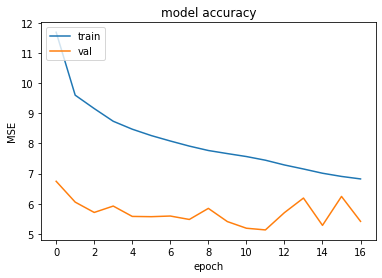

Epoch 1/100
1176/1176 [==============================] - 1s 859us/step - loss: 18.6308 - mse: 18.6308 - val_loss: 6.6014 - val_mse: 6.6014
Epoch 2/100
1176/1176 [==============================] - 1s 690us/step - loss: 9.7900 - mse: 9.7900 - val_loss: 6.4374 - val_mse: 6.4374
Epoch 3/100
1176/1176 [==============================] - 1s 692us/step - loss: 9.3120 - mse: 9.3120 - val_loss: 5.9531 - val_mse: 5.9531
Epoch 4/100
1176/1176 [==============================] - 1s 696us/step - loss: 8.6365 - mse: 8.6365 - val_loss: 5.5504 - val_mse: 5.5504
Epoch 5/100
1176/1176 [==============================] - 1s 695us/step - loss: 8.1107 - mse: 8.1107 - val_loss: 5.3731 - val_mse: 5.3731
Epoch 6/100
1176/1176 [==============================] - 1s 698us/step - loss: 7.5001 - mse: 7.5001 - val_loss: 6.7810 - val_mse: 6.7810
Epoch 7/100
1176/1176 [==============================] - 1s 697us/step - loss: 7.1441 - mse: 7.1441 - val_loss: 5.4989 - val_mse: 5.4989
Epoch 8/100
1176/1176 [================

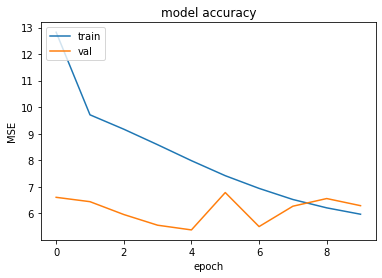

Epoch 1/100
1176/1176 [==============================] - 1s 762us/step - loss: 16.1992 - mse: 16.1992 - val_loss: 6.3656 - val_mse: 6.3656
Epoch 2/100
1176/1176 [==============================] - 1s 695us/step - loss: 9.5467 - mse: 9.5467 - val_loss: 6.2328 - val_mse: 6.2328
Epoch 3/100
1176/1176 [==============================] - 1s 694us/step - loss: 8.9875 - mse: 8.9875 - val_loss: 6.7739 - val_mse: 6.7739
Epoch 4/100
1176/1176 [==============================] - 1s 695us/step - loss: 8.3453 - mse: 8.3453 - val_loss: 7.7168 - val_mse: 7.7168
Epoch 5/100
1176/1176 [==============================] - 1s 689us/step - loss: 7.9178 - mse: 7.9178 - val_loss: 7.6798 - val_mse: 7.6798
Epoch 6/100
1176/1176 [==============================] - 1s 694us/step - loss: 7.7526 - mse: 7.7526 - val_loss: 7.7889 - val_mse: 7.7889
Epoch 7/100
1176/1176 [==============================] - 1s 694us/step - loss: 7.6026 - mse: 7.6026 - val_loss: 8.1610 - val_mse: 8.1610


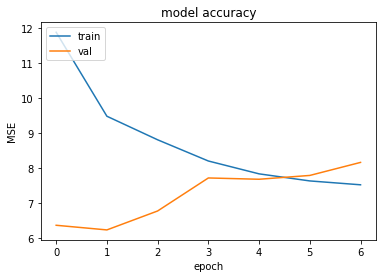

Epoch 1/100
1176/1176 [==============================] - 1s 755us/step - loss: 17.3322 - mse: 17.3322 - val_loss: 6.6877 - val_mse: 6.6877
Epoch 2/100
1176/1176 [==============================] - 1s 684us/step - loss: 9.4560 - mse: 9.4560 - val_loss: 6.3566 - val_mse: 6.3566
Epoch 3/100
1176/1176 [==============================] - 1s 687us/step - loss: 9.0422 - mse: 9.0422 - val_loss: 6.0776 - val_mse: 6.0776
Epoch 4/100
1176/1176 [==============================] - 1s 682us/step - loss: 8.0697 - mse: 8.0697 - val_loss: 5.6357 - val_mse: 5.6357
Epoch 5/100
1176/1176 [==============================] - 1s 686us/step - loss: 7.5718 - mse: 7.5718 - val_loss: 5.1656 - val_mse: 5.1656
Epoch 6/100
1176/1176 [==============================] - 1s 682us/step - loss: 7.0960 - mse: 7.0960 - val_loss: 4.6843 - val_mse: 4.6843
Epoch 7/100
1176/1176 [==============================] - 1s 689us/step - loss: 6.8012 - mse: 6.8012 - val_loss: 4.5095 - val_mse: 4.5095
Epoch 8/100
1176/1176 [================

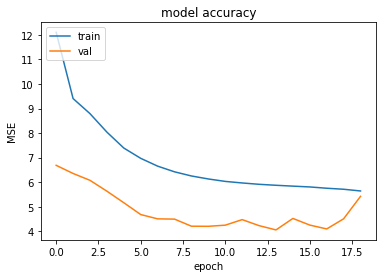

Epoch 1/100
1176/1176 [==============================] - 1s 755us/step - loss: 16.0094 - mse: 16.0094 - val_loss: 6.3330 - val_mse: 6.3330
Epoch 2/100
1176/1176 [==============================] - 1s 688us/step - loss: 9.4453 - mse: 9.4453 - val_loss: 5.6542 - val_mse: 5.6542
Epoch 3/100
1176/1176 [==============================] - 1s 698us/step - loss: 8.8540 - mse: 8.8540 - val_loss: 5.3359 - val_mse: 5.3359
Epoch 4/100
1176/1176 [==============================] - 1s 691us/step - loss: 8.2203 - mse: 8.2203 - val_loss: 5.0207 - val_mse: 5.0207
Epoch 5/100
1176/1176 [==============================] - 1s 689us/step - loss: 7.5397 - mse: 7.5397 - val_loss: 5.2728 - val_mse: 5.2728
Epoch 6/100
1176/1176 [==============================] - 1s 696us/step - loss: 6.8560 - mse: 6.8560 - val_loss: 5.0503 - val_mse: 5.0503
Epoch 7/100
1176/1176 [==============================] - 1s 696us/step - loss: 6.5157 - mse: 6.5157 - val_loss: 4.8155 - val_mse: 4.8155
Epoch 8/100
1176/1176 [================

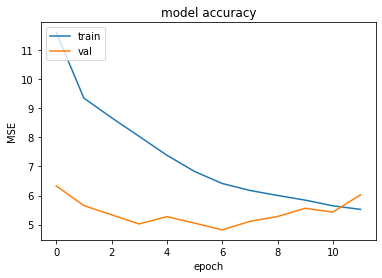

Epoch 1/100
1176/1176 [==============================] - 1s 760us/step - loss: 15.6550 - mse: 15.6550 - val_loss: 6.5064 - val_mse: 6.5064
Epoch 2/100
1176/1176 [==============================] - 1s 690us/step - loss: 9.4541 - mse: 9.4541 - val_loss: 6.5314 - val_mse: 6.5314
Epoch 3/100
1176/1176 [==============================] - 1s 687us/step - loss: 8.6506 - mse: 8.6506 - val_loss: 6.1010 - val_mse: 6.1010
Epoch 4/100
1176/1176 [==============================] - 1s 691us/step - loss: 7.9260 - mse: 7.9260 - val_loss: 5.5347 - val_mse: 5.5347
Epoch 5/100
1176/1176 [==============================] - 1s 689us/step - loss: 7.0424 - mse: 7.0424 - val_loss: 6.0489 - val_mse: 6.0489
Epoch 6/100
1176/1176 [==============================] - 1s 688us/step - loss: 6.5473 - mse: 6.5473 - val_loss: 6.0670 - val_mse: 6.0670
Epoch 7/100
1176/1176 [==============================] - 1s 686us/step - loss: 6.2096 - mse: 6.2096 - val_loss: 5.2240 - val_mse: 5.2240
Epoch 8/100
1176/1176 [================

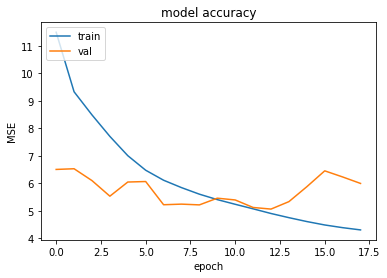

,Structure,Val MSE,Epochs
0,[10],5.973265,7
1,[11],6.522359,8
2,[12],6.029320,9
3,[13],5.132332,17
4,[14],5.373082,10
5,[15],6.232838,7
6,[16],4.059046,19
7,[17],4.815453,12
8,[20],5.066199,18


In [124]:
structures = [[10], [11], [12], [13], [14], [15], [16], [17], [20]]

data = []

for structure in structures:
    X_train = X
    y_train = y
    input_dim = X_train.shape[1]
    output_dim = 1

    # Set up the session config to limit GPU memory usage
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(session)

    # Create the model
    with tf.device('/GPU:0'): # specify the GPU to use
        model = create_mlp(input_dim, structure, output_dim)

        # Compile the model with an optimizer and loss function
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

        # Train the model with early stopping
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])

        plt.plot(history.history['mse'])
        plt.plot(history.history['val_mse'])
        plt.title('model accuracy')
        plt.ylabel('MSE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        data.append([structure, min(history.history['val_mse']), len(history.history['val_mse'])])

df = pd.DataFrame(data, columns=('Structure', 'Val MSE', 'Epochs'))
df_sorted = df.sort_values(by='Val MSE')
df_sorted

Epoch 1/100
1176/1176 [==============================] - 1s 886us/step - loss: 17.3387 - mse: 17.3387 - val_loss: 6.5379 - val_mse: 6.5379
Epoch 2/100
1176/1176 [==============================] - 1s 702us/step - loss: 9.4359 - mse: 9.4359 - val_loss: 6.0895 - val_mse: 6.0895
Epoch 3/100
1176/1176 [==============================] - 1s 707us/step - loss: 8.1559 - mse: 8.1559 - val_loss: 5.7346 - val_mse: 5.7346
Epoch 4/100
1176/1176 [==============================] - 1s 707us/step - loss: 6.5974 - mse: 6.5974 - val_loss: 4.5837 - val_mse: 4.5837
Epoch 5/100
1176/1176 [==============================] - 1s 706us/step - loss: 5.7440 - mse: 5.7440 - val_loss: 4.8284 - val_mse: 4.8284
Epoch 6/100
1176/1176 [==============================] - 1s 706us/step - loss: 5.2075 - mse: 5.2075 - val_loss: 4.3904 - val_mse: 4.3904
Epoch 7/100
1176/1176 [==============================] - 1s 704us/step - loss: 4.7291 - mse: 4.7291 - val_loss: 4.0817 - val_mse: 4.0817
Epoch 8/100
1176/1176 [================

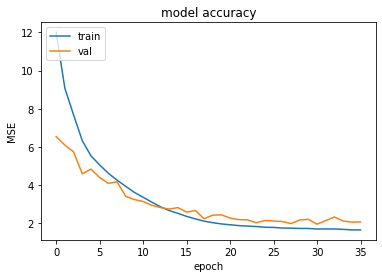

Epoch 1/100
1176/1176 [==============================] - 1s 862us/step - loss: 12.8024 - mse: 12.8024 - val_loss: 7.2132 - val_mse: 7.2132
Epoch 2/100
1176/1176 [==============================] - 1s 713us/step - loss: 8.7970 - mse: 8.7970 - val_loss: 7.4217 - val_mse: 7.4217
Epoch 3/100
1176/1176 [==============================] - 1s 706us/step - loss: 6.8447 - mse: 6.8447 - val_loss: 7.1326 - val_mse: 7.1326
Epoch 4/100
1176/1176 [==============================] - 1s 707us/step - loss: 5.5633 - mse: 5.5633 - val_loss: 6.9785 - val_mse: 6.9785
Epoch 5/100
1176/1176 [==============================] - 1s 710us/step - loss: 4.8982 - mse: 4.8982 - val_loss: 8.2247 - val_mse: 8.2247
Epoch 6/100
1176/1176 [==============================] - 1s 705us/step - loss: 4.6239 - mse: 4.6239 - val_loss: 9.2640 - val_mse: 9.2640
Epoch 7/100
1176/1176 [==============================] - 1s 706us/step - loss: 4.3449 - mse: 4.3449 - val_loss: 7.2507 - val_mse: 7.2507
Epoch 8/100
1176/1176 [================

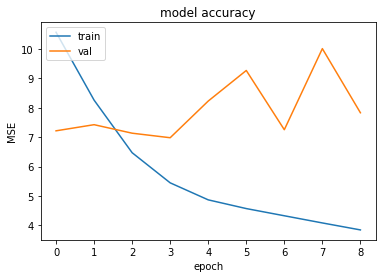

Epoch 1/100
1176/1176 [==============================] - 1s 789us/step - loss: 17.8070 - mse: 17.8070 - val_loss: 6.5782 - val_mse: 6.5782
Epoch 2/100
1176/1176 [==============================] - 1s 717us/step - loss: 9.6083 - mse: 9.6083 - val_loss: 6.1834 - val_mse: 6.1834
Epoch 3/100
1176/1176 [==============================] - 1s 716us/step - loss: 7.9636 - mse: 7.9636 - val_loss: 5.3810 - val_mse: 5.3810
Epoch 4/100
1176/1176 [==============================] - 1s 718us/step - loss: 6.3703 - mse: 6.3703 - val_loss: 4.8519 - val_mse: 4.8519
Epoch 5/100
1176/1176 [==============================] - 1s 717us/step - loss: 5.4875 - mse: 5.4875 - val_loss: 4.6892 - val_mse: 4.6892
Epoch 6/100
1176/1176 [==============================] - 1s 715us/step - loss: 5.1300 - mse: 5.1300 - val_loss: 4.5495 - val_mse: 4.5495
Epoch 7/100
1176/1176 [==============================] - 1s 720us/step - loss: 4.8451 - mse: 4.8451 - val_loss: 4.4367 - val_mse: 4.4367
Epoch 8/100
1176/1176 [================

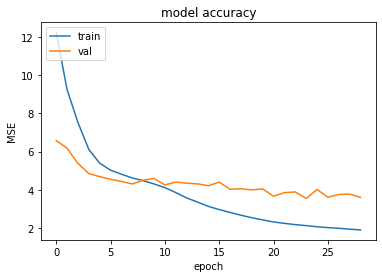

Epoch 1/100
1176/1176 [==============================] - 1s 774us/step - loss: 15.9111 - mse: 15.9111 - val_loss: 6.0588 - val_mse: 6.0588
Epoch 2/100
1176/1176 [==============================] - 1s 705us/step - loss: 8.4575 - mse: 8.4575 - val_loss: 4.7896 - val_mse: 4.7896
Epoch 3/100
1176/1176 [==============================] - 1s 701us/step - loss: 6.5777 - mse: 6.5777 - val_loss: 4.1985 - val_mse: 4.1985
Epoch 4/100
1176/1176 [==============================] - 1s 705us/step - loss: 5.6253 - mse: 5.6253 - val_loss: 4.0558 - val_mse: 4.0558
Epoch 5/100
1176/1176 [==============================] - 1s 704us/step - loss: 5.2915 - mse: 5.2915 - val_loss: 3.8709 - val_mse: 3.8709
Epoch 6/100
1176/1176 [==============================] - 1s 701us/step - loss: 5.0231 - mse: 5.0231 - val_loss: 3.8868 - val_mse: 3.8868
Epoch 7/100
1176/1176 [==============================] - 1s 703us/step - loss: 4.4964 - mse: 4.4964 - val_loss: 3.6587 - val_mse: 3.6587
Epoch 8/100
1176/1176 [================

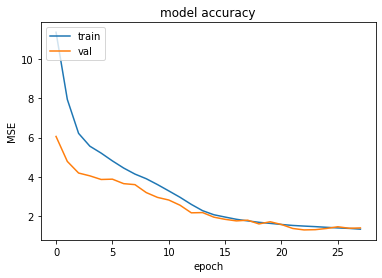

Epoch 1/100
1176/1176 [==============================] - 1s 877us/step - loss: 17.8400 - mse: 17.8400 - val_loss: 6.4259 - val_mse: 6.4259
Epoch 2/100
1176/1176 [==============================] - 1s 707us/step - loss: 8.6230 - mse: 8.6230 - val_loss: 5.3281 - val_mse: 5.3281
Epoch 3/100
1176/1176 [==============================] - 1s 709us/step - loss: 6.3808 - mse: 6.3808 - val_loss: 3.8344 - val_mse: 3.8344
Epoch 4/100
1176/1176 [==============================] - 1s 709us/step - loss: 5.3831 - mse: 5.3831 - val_loss: 3.7502 - val_mse: 3.7502
Epoch 5/100
1176/1176 [==============================] - 1s 708us/step - loss: 4.8840 - mse: 4.8840 - val_loss: 3.4513 - val_mse: 3.4513
Epoch 6/100
1176/1176 [==============================] - 1s 713us/step - loss: 4.3840 - mse: 4.3840 - val_loss: 3.1442 - val_mse: 3.1442
Epoch 7/100
1176/1176 [==============================] - 1s 709us/step - loss: 4.1988 - mse: 4.1988 - val_loss: 2.9382 - val_mse: 2.9382
Epoch 8/100
1176/1176 [================

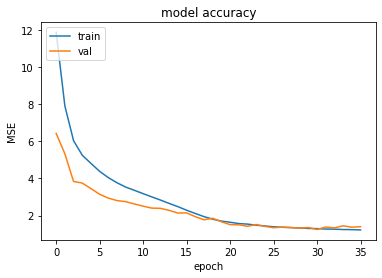

Epoch 1/100
1176/1176 [==============================] - 1s 786us/step - loss: 13.7172 - mse: 13.7172 - val_loss: 5.9533 - val_mse: 5.9533
Epoch 2/100
1176/1176 [==============================] - 1s 717us/step - loss: 9.3647 - mse: 9.3647 - val_loss: 4.7932 - val_mse: 4.7932
Epoch 3/100
1176/1176 [==============================] - 1s 716us/step - loss: 7.4941 - mse: 7.4941 - val_loss: 3.9959 - val_mse: 3.9959
Epoch 4/100
1176/1176 [==============================] - 1s 725us/step - loss: 5.8204 - mse: 5.8204 - val_loss: 3.3570 - val_mse: 3.3570
Epoch 5/100
1176/1176 [==============================] - 1s 715us/step - loss: 4.9381 - mse: 4.9381 - val_loss: 3.0359 - val_mse: 3.0359
Epoch 6/100
1176/1176 [==============================] - 1s 722us/step - loss: 4.1471 - mse: 4.1471 - val_loss: 2.7631 - val_mse: 2.7631
Epoch 7/100
1176/1176 [==============================] - 1s 800us/step - loss: 3.4458 - mse: 3.4458 - val_loss: 2.1091 - val_mse: 2.1091
Epoch 8/100
1176/1176 [================

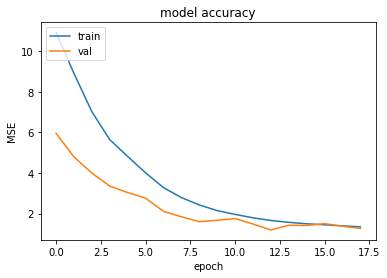

,Structure,Val MSE,Epochs
5,"[16, 15]",1.195226,18
4,"[16, 14]",1.247525,36
3,"[16, 13]",1.306049,28
0,"[16, 10]",1.941181,36
2,"[16, 12]",3.540941,29
1,"[16, 11]",6.978477,9


In [126]:
structures = [[16, 10], [16, 11], [16, 12], [16, 13], [16, 14], [16, 15]]

data = []

for structure in structures:
    X_train = X
    y_train = y
    input_dim = X_train.shape[1]
    output_dim = 1

    # Set up the session config to limit GPU memory usage
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(session)

    # Create the model
    with tf.device('/GPU:0'): # specify the GPU to use
        model = create_mlp(input_dim, structure, output_dim)

        # Compile the model with an optimizer and loss function
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

        # Train the model with early stopping
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])

        plt.plot(history.history['mse'])
        plt.plot(history.history['val_mse'])
        plt.title('model accuracy')
        plt.ylabel('MSE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        data.append([structure, min(history.history['val_mse']), len(history.history['val_mse'])])

df = pd.DataFrame(data, columns=('Structure', 'Val MSE', 'Epochs'))
df_sorted = df.sort_values(by='Val MSE')
df_sorted

Epoch 1/100
1505/1505 [==============================] - 1s 775us/step - loss: 0.3365 - mse: 0.3365 - val_loss: 0.1848 - val_mse: 0.1848
Epoch 2/100
1505/1505 [==============================] - 1s 713us/step - loss: 0.1627 - mse: 0.1627 - val_loss: 0.1217 - val_mse: 0.1217
Epoch 3/100
1505/1505 [==============================] - 1s 714us/step - loss: 0.1050 - mse: 0.1050 - val_loss: 0.0836 - val_mse: 0.0836
Epoch 4/100
1505/1505 [==============================] - 1s 718us/step - loss: 0.0649 - mse: 0.0649 - val_loss: 0.0529 - val_mse: 0.0529
Epoch 5/100
1505/1505 [==============================] - 1s 715us/step - loss: 0.0393 - mse: 0.0393 - val_loss: 0.0590 - val_mse: 0.0590
Epoch 6/100
1505/1505 [==============================] - 1s 714us/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0477 - val_mse: 0.0477
Epoch 7/100
1505/1505 [==============================] - 1s 716us/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0452 - val_mse: 0.0452
Epoch 8/100
1505/1505 [==================

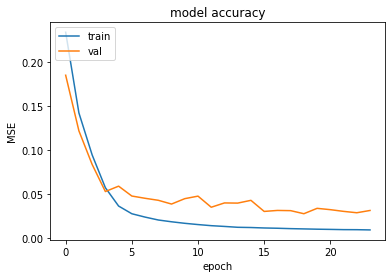

Epoch 1/100
1505/1505 [==============================] - 1s 778us/step - loss: 0.5032 - mse: 0.5032 - val_loss: 0.1864 - val_mse: 0.1864
Epoch 2/100
1505/1505 [==============================] - 1s 722us/step - loss: 0.1386 - mse: 0.1386 - val_loss: 0.2881 - val_mse: 0.2881
Epoch 3/100
1505/1505 [==============================] - 1s 728us/step - loss: 0.0759 - mse: 0.0759 - val_loss: 0.2966 - val_mse: 0.2966
Epoch 4/100
1505/1505 [==============================] - 1s 726us/step - loss: 0.0441 - mse: 0.0441 - val_loss: 0.1525 - val_mse: 0.1525
Epoch 5/100
1505/1505 [==============================] - 1s 738us/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.1109 - val_mse: 0.1109
Epoch 6/100
1505/1505 [==============================] - 1s 732us/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.1561 - val_mse: 0.1561
Epoch 7/100
1505/1505 [==============================] - 1s 727us/step - loss: 0.0262 - mse: 0.0262 - val_loss: 0.1034 - val_mse: 0.1034
Epoch 8/100
1505/1505 [==================

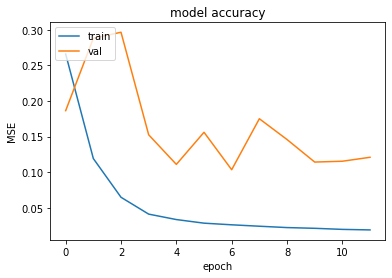

Epoch 1/100
1505/1505 [==============================] - 2s 814us/step - loss: 0.4411 - mse: 0.4411 - val_loss: 0.1787 - val_mse: 0.1787
Epoch 2/100
1505/1505 [==============================] - 1s 749us/step - loss: 0.1417 - mse: 0.1417 - val_loss: 0.0899 - val_mse: 0.0899
Epoch 3/100
1505/1505 [==============================] - 1s 755us/step - loss: 0.0524 - mse: 0.0524 - val_loss: 0.0720 - val_mse: 0.0720
Epoch 4/100
1505/1505 [==============================] - 1s 754us/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0812 - val_mse: 0.0812
Epoch 5/100
1505/1505 [==============================] - 1s 753us/step - loss: 0.0221 - mse: 0.0221 - val_loss: 0.0809 - val_mse: 0.0809
Epoch 6/100
1505/1505 [==============================] - 1s 757us/step - loss: 0.0182 - mse: 0.0182 - val_loss: 0.0705 - val_mse: 0.0705
Epoch 7/100
1505/1505 [==============================] - 1s 752us/step - loss: 0.0155 - mse: 0.0155 - val_loss: 0.0633 - val_mse: 0.0633
Epoch 8/100
1505/1505 [==================

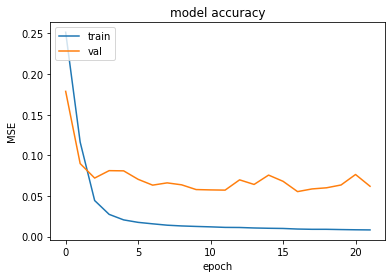

Epoch 1/100
1505/1505 [==============================] - 2s 826us/step - loss: 1.1550 - mse: 1.1550 - val_loss: 0.2216 - val_mse: 0.2216
Epoch 2/100
1505/1505 [==============================] - 1s 754us/step - loss: 0.1746 - mse: 0.1746 - val_loss: 0.4095 - val_mse: 0.4095
Epoch 3/100
1505/1505 [==============================] - 1s 754us/step - loss: 0.1328 - mse: 0.1328 - val_loss: 0.7286 - val_mse: 0.7286
Epoch 4/100
1505/1505 [==============================] - 1s 756us/step - loss: 0.1004 - mse: 0.1004 - val_loss: 0.5264 - val_mse: 0.5264
Epoch 5/100
1505/1505 [==============================] - 1s 763us/step - loss: 0.0699 - mse: 0.0699 - val_loss: 0.5396 - val_mse: 0.5396
Epoch 6/100
1505/1505 [==============================] - 1s 755us/step - loss: 0.0423 - mse: 0.0423 - val_loss: 0.4994 - val_mse: 0.4994


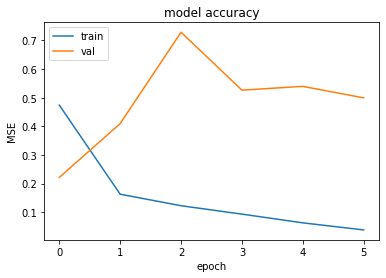

,Structure,Val MSE,Epochs
0,"[23, 16, 12]",0.027684,24
2,"[23, 16, 12, 9, 7]",0.055360,22
1,"[23, 16, 12, 9]",0.103446,12
3,"[23, 16, 12, 9, 7, 5]",0.221605,6


In [9]:
structures = [[23, 16], [23, 16, 12], [32, 16], [23, 16, 12, 9]]
structures = [[23, 16, 12], [23, 16, 12, 9], [23, 16, 12, 9, 7], [23, 16, 12, 9, 7, 5]]

data = []

for structure in structures:
    X_train = X
    y_train = y_log
    input_dim = X_train.shape[1]
    output_dim = 1

    # Set up the session config to limit GPU memory usage
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(session)

    # Create the model
    with tf.device('/GPU:0'): # specify the GPU to use
        model = create_mlp(input_dim, structure, output_dim)

        # Compile the model with an optimizer and loss function
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

        # Train the model with early stopping
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stop])

        plt.plot(history.history['mse'])
        plt.plot(history.history['val_mse'])
        plt.title('model accuracy')
        plt.ylabel('MSE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        data.append([structure, min(history.history['val_mse']), len(history.history['val_mse'])])

df = pd.DataFrame(data, columns=('Structure', 'Val MSE', 'Epochs'))
df_sorted = df.sort_values(by='Val MSE')
df_sorted

Epoch 1/100
1204/1204 [==============================] - 1s 858us/step - loss: 12.1145 - mse: 12.1145 - val_loss: 6.1489 - val_mse: 6.1489
Epoch 2/100
1204/1204 [==============================] - 1s 767us/step - loss: 5.2961 - mse: 5.2961 - val_loss: 4.6161 - val_mse: 4.6161
Epoch 3/100
1204/1204 [==============================] - 1s 770us/step - loss: 4.3576 - mse: 4.3576 - val_loss: 4.4928 - val_mse: 4.4928
Epoch 4/100
1204/1204 [==============================] - 1s 770us/step - loss: 3.2802 - mse: 3.2802 - val_loss: 2.7633 - val_mse: 2.7633
Epoch 5/100
1204/1204 [==============================] - 1s 768us/step - loss: 2.4850 - mse: 2.4850 - val_loss: 1.9825 - val_mse: 1.9825
Epoch 6/100
1204/1204 [==============================] - 1s 768us/step - loss: 1.7976 - mse: 1.7976 - val_loss: 1.5203 - val_mse: 1.5203
Epoch 7/100
1204/1204 [==============================] - 1s 774us/step - loss: 1.3416 - mse: 1.3416 - val_loss: 1.1234 - val_mse: 1.1234
Epoch 8/100
1204/1204 [================

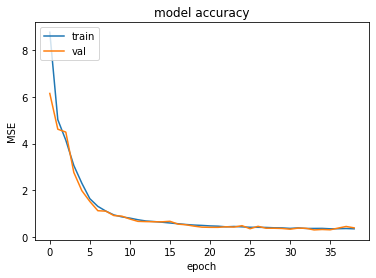

,Structure,Val MSE,Epochs
0,"[23, 16, 12, 9, 7, 5]",0.300854,39


In [23]:
structure = [23, 16, 12, 9, 7, 5]
data = []
# X_train = X
# y_train = y_log
input_dim = X_train.shape[1]
output_dim = 1

# Set up the session config to limit GPU memory usage
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
model = 0

# Create the model
with tf.device('/GPU:0'): # specify the GPU to use
    model = create_mlp(input_dim, structure, output_dim)

    # Compile the model with an optimizer and loss function
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

    # Train the model with early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stop])

    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('model accuracy')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    data.append([structure, min(history.history['val_mse']), len(history.history['val_mse'])])

df = pd.DataFrame(data, columns=('Structure', 'Val MSE', 'Epochs'))
df_sorted = df.sort_values(by='Val MSE')
df_sorted

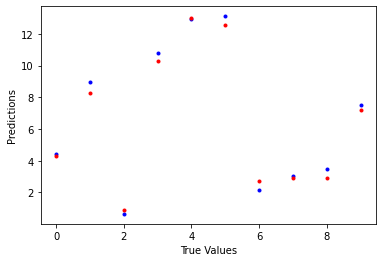

In [24]:
y_pred = model.predict(X_test)

# Plot MSE
num = 10
plt.plot(range(num), y_test[:num], '.', color='blue')
plt.plot(range(num), y_pred[:num], '.', color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()